In [1]:
from projectq import MainEngine  # import the main compiler engine
from projectq.ops import (
    H,
    Measure,
)  # import the operations we want to perform (Hadamard and measurement)

eng = MainEngine()  # create a default compiler (the back-end is a simulator)
qubit = eng.allocate_qubit()  # allocate 1 qubit

H | qubit  # apply a Hadamard gate
Measure | qubit  # measure the qubit

eng.flush()  # flush all gates (and execute measurements)
print(f"Measured {int(qubit)}")  # output measurement result

Measured 0


In [2]:
"""Example of a simple quantum random number generator."""

from projectq import MainEngine
from projectq.ops import H, Measure

# create a main compiler engine
eng = MainEngine()

# allocate one qubit
q1 = eng.allocate_qubit()

# put it in superposition
H | q1

# measure
Measure | q1

eng.flush()
# print the result:
print(f"Measured: {int(q1)}")

Measured: 0


# Bell pair creation

In [6]:
%env MAGICK_HOME=/home/linuxbrew/.linuxbrew/opt/imagemagick
from wand.image import Image as WImage
import matplotlib.pyplot as plt

def draw_tek(s, figsize=(4,4)):
    with open("output.tex", "w") as file:
        file.write(s) 
    !pdflatex output.tex > /dev/null
    img = WImage(filename='output.pdf', resolution=1600)
    plt.figure(figsize = figsize)
    plt.axis("off")
    plt.imshow(img)

env: MAGICK_HOME=/home/linuxbrew/.linuxbrew/opt/imagemagick


In [7]:
"""Example of a quantum teleportation circuit."""

from projectq import MainEngine
from projectq.meta import Control, Dagger
from projectq.ops import CNOT, H, Measure, Rz, X, Z, All


def create_bell_pair(eng):
    r"""
    Create a Bell pair state with two qubits.

    Returns a Bell-pair (two qubits in state :math:`|A\rangle \otimes |B \rangle = \frac 1{\sqrt 2} \left(
    |0\rangle\otimes|0\rangle + |1\rangle \otimes|1\rangle \right)`).

    Args:
        eng (MainEngine): MainEngine from which to allocate the qubits.

    Returns:
        bell_pair (tuple<Qubits>): The Bell-pair.
    """
    b1 = eng.allocate_qureg(1)[0]
    b2 = eng.allocate_qureg(1)[0]

    H | b1
    CNOT | (b1, b2)

    return b1, b2


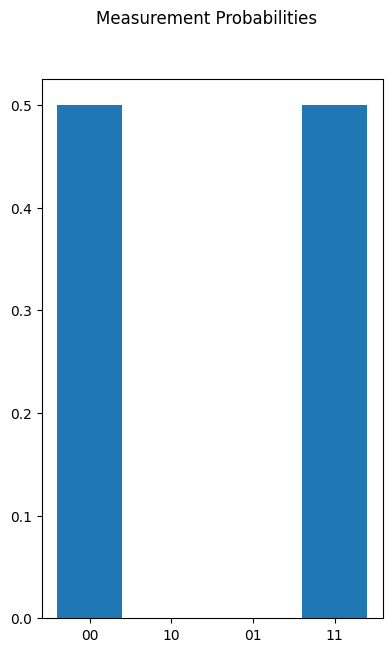

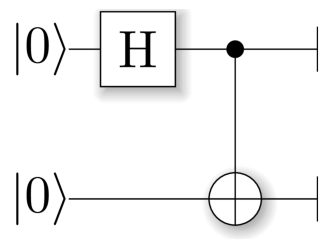

In [8]:
"""Example implementation of a quantum circuit generating a Bell pair state."""

import matplotlib.pyplot as plt
#from teleport import create_bell_pair

from projectq import MainEngine
from projectq.backends import CircuitDrawer
from projectq.libs.hist import histogram
from projectq.setups.default import get_engine_list
from projectq.meta import Compute, Uncompute

# create a main compiler engine
drawing_engine = CircuitDrawer()

eng = MainEngine(engine_list=get_engine_list() + [drawing_engine])

qb0, qb1 = create_bell_pair(eng)
eng.flush()

histogram(eng.backend, [qb0, qb1])
plt.show()

# clear qureg bits
eng.backend.collapse_wavefunction([qb0, qb1], [0, 0])
del qb0, qb1

s = drawing_engine.get_latex()
draw_tek(s)


# Quantum Teleportation

In [9]:
from projectq import MainEngine
from projectq.backends import CircuitDrawer
from projectq.meta import Control, Dagger
from projectq.ops import CNOT, H, Measure, Rz, X, Z

In [10]:
def create_bell_pair(eng):
    r"""
    Create a Bell pair state with two qubits.

    Returns a Bell-pair (two qubits in state :math:`|A\rangle \otimes |B \rangle = \frac 1{\sqrt 2} \left(
    |0\rangle\otimes|0\rangle + |1\rangle \otimes|1\rangle \right)`).

    Args:
        eng (MainEngine): MainEngine from which to allocate the qubits.

    Returns:
        bell_pair (tuple<Qubits>): The Bell-pair.
    """
    b1 = eng.allocate_qubit()
    b2 = eng.allocate_qubit()

    H | b1
    CNOT | (b1, b2)

    return b1, b2

def run_teleport(eng, state_creation_function, verbose=False):
    """
    Run quantum teleportation on the provided main compiler engine.

    Creates a state from |0> using the state_creation_function, teleports this state to Bob who then tries to
    uncompute his qubit using the inverse of the state_creation_function. If successful, deleting the qubit won't
    raise an error in the underlying Simulator back-end (else it will).

    Args:
        eng (MainEngine): Main compiler engine to run the circuit on.
        state_creation_function (function): Function which accepts the main engine and a qubit in state |0>, which it
            then transforms to the state that Alice would like to send to Bob.
        verbose (bool): If True, info messages will be printed.

    """
    # make a Bell-pair
    b1, b2 = create_bell_pair(eng)

    # Alice creates a nice state to send
    psi = eng.allocate_qubit()
    if verbose:
        print("Alice is creating her state from scratch, i.e., |0>.")
    state_creation_function(eng, psi)

    # entangle it with Alice's b1
    CNOT | (psi, b1)
    if verbose:
        print("Alice entangled her qubit with her share of the Bell-pair.")

    # measure two values (once in Hadamard basis) and send the bits to Bob
    H | psi
    Measure | psi
    Measure | b1
    msg_to_bob = [int(psi), int(b1)]
    if verbose:
        print(f"Alice is sending the message {msg_to_bob} to Bob.")

    # Bob may have to apply up to two operation depending on the message sent
    # by Alice:
    with Control(eng, b1):
        X | b2
    with Control(eng, psi):
        Z | b2

    # try to uncompute the psi state
    if verbose:
        print("Bob is trying to uncompute the state.")
    with Dagger(eng):
        state_creation_function(eng, b2)

    # check whether the uncompute was successful. The simulator only allows to
    # delete qubits which are in a computational basis state.
    del b2
    eng.flush()

    if verbose:
        print("Bob successfully arrived at |0>")

In [11]:
# create a main compiler engine with a simulator backend:
drawing_engine = CircuitDrawer()
locations = {0: 1, 1: 2, 2: 0}
drawing_engine.set_qubit_locations(locations)
eng = MainEngine(drawing_engine)

# we just want to draw the teleportation circuit
def create_state(eng, qb):
    """Create a quantum state."""

# run the teleport and then, let Bob try to uncompute his qubit:
run_teleport(eng, create_state, verbose=True)

# print latex code to draw the circuit:
s = drawing_engine.get_latex()
#print(s)

Alice is creating her state from scratch, i.e., |0>.
Alice entangled her qubit with her share of the Bell-pair.
Alice is sending the message [0, 0] to Bob.
Bob is trying to uncompute the state.
Bob successfully arrived at |0>


In [12]:
# modify input states
s_mod = s.replace(r'$\Ket{0}$', r'$\Ket{\psi}$', 1)
s_mod = s_mod.replace(r'$\Ket{0}$', r'$\Ket{0}_A$', 1)
s_mod = s_mod.replace(r'$\Ket{0}$', r'$\Ket{0}_B$', 1)
# add output states
s_mod = s_mod.replace(r'\end{tikzpicture}', r'\node[none] (line2_gate5) at (5.7,-2) {$\Ket{\psi}$};\end{tikzpicture}')

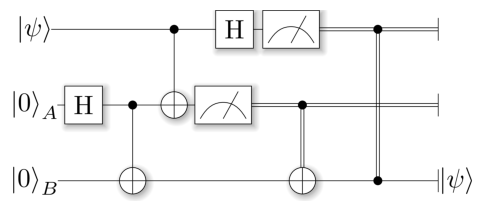

In [13]:
# Z gate is not shown. why????
draw_tek(s_mod, figsize=(6,6))

In [14]:
from projectq.ops import CNOT, H, Measure, Rz, X, Z, Rx
# create a main compiler engine with a simulator backend:
drawing_engine = CircuitDrawer()
locations = {0: 1, 1: 2, 2: 0}
drawing_engine.set_qubit_locations(locations)
eng = MainEngine(drawing_engine)

# we just want to draw the teleportation circuit
def create_state(eng, qb):
    """Create a quantum state."""
    #H | qb
    Rx(1) | qb

# run the teleport and then, let Bob try to uncompute his qubit:
run_teleport(eng, create_state, verbose=True)

Alice is creating her state from scratch, i.e., |0>.
Alice entangled her qubit with her share of the Bell-pair.
Alice is sending the message [0, 0] to Bob.
Bob is trying to uncompute the state.
Bob successfully arrived at |0>


# Mach-Zehnder Interferometer

b0 = (1+0j) 0j
b0 = (0.7071067811865475+0j) (0.7071067811865475+0j)
b0 = (0.7071067811865475+0j) (0.7071067811865475+0j)
b0 = (0.9999999999999998+0j) 0j
Measured 0


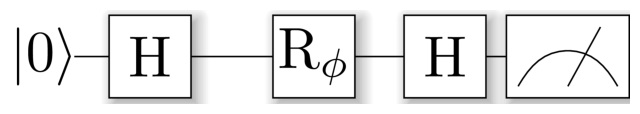

In [15]:
import matplotlib.pyplot as plt

from projectq import MainEngine
from projectq.backends import CircuitDrawer
from projectq.libs.hist import histogram
from projectq.setups.default import get_engine_list
from projectq.ops import CNOT, H, Measure, Rz, X, Z, Rx, Ry, R
from projectq.meta import Control, Dagger

from math import pi

# create a main compiler engine
drawing_engine = CircuitDrawer()
eng = MainEngine(engine_list=get_engine_list() + [drawing_engine])
b0 = eng.allocate_qubit()
eng.flush()
a = eng.backend.get_amplitude('0', b0)
b = eng.backend.get_amplitude('1', b0)
print('b0 =', a, b)
H | b0
#Measure | b0
eng.flush()
a = eng.backend.get_amplitude('0', b0)
b = eng.backend.get_amplitude('1', b0)
print('b0 =', a, b)
R(0.0*pi) | b0
eng.flush()
a = eng.backend.get_amplitude('0', b0)
b = eng.backend.get_amplitude('1', b0)
print('b0 =', a, b)
#with Dagger(eng):
#    H | b0
H | b0
eng.flush()
a = eng.backend.get_amplitude('0', b0)
b = eng.backend.get_amplitude('1', b0)
print('b0 =', a, b)
Measure | b0
eng.flush()
print(f"Measured {int(b0)}")  # output measurement result
#histogram(eng.backend, [b0])

s = drawing_engine.get_latex()

import re
# remove floating number subscription in R gate
s = re.sub(r'{R\$_{\d+.\d+}\$}', r'{R$_{\\phi}$}', s)

draw_tek(s, figsize=(8,8))


b0 = (1+0j) 0j
b0 = 0j (1+0j)
b0 = 0j (1+0j)
b0 = (0.7071067811865475+0j) (-0.7071067811865475+0j)
Measured 1


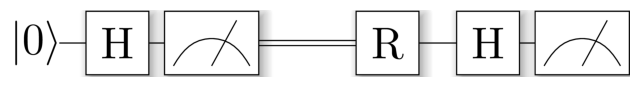

In [16]:
import matplotlib.pyplot as plt

from projectq import MainEngine
from projectq.backends import CircuitDrawer
from projectq.libs.hist import histogram
from projectq.setups.default import get_engine_list
from projectq.ops import CNOT, H, Measure, Rz, X, Z, Rx, Ry, R

from math import pi

# create a main compiler engine
drawing_engine = CircuitDrawer()
eng = MainEngine(engine_list=get_engine_list() + [drawing_engine])
b0 = eng.allocate_qubit()
eng.flush()
a = eng.backend.get_amplitude('0', b0)
b = eng.backend.get_amplitude('1', b0)
print('b0 =', a, b)
H | b0
Measure | b0
eng.flush()
a = eng.backend.get_amplitude('0', b0)
b = eng.backend.get_amplitude('1', b0)
print('b0 =', a, b)
R(0.0*pi) | b0
eng.flush()
a = eng.backend.get_amplitude('0', b0)
b = eng.backend.get_amplitude('1', b0)
print('b0 =', a, b)
with Dagger(eng):
    H | b0
eng.flush()
a = eng.backend.get_amplitude('0', b0)
b = eng.backend.get_amplitude('1', b0)
print('b0 =', a, b)
Measure | b0
eng.flush()
print(f"Measured {int(b0)}")  # output measurement result
#histogram(eng.backend, [b0])

s = drawing_engine.get_latex()

import re
# remove floating number subscription in R gate
s = re.sub(r'{R\$_{\d+.\d+}\$}', '{R}', s)

draw_tek(s, figsize=(8,8))


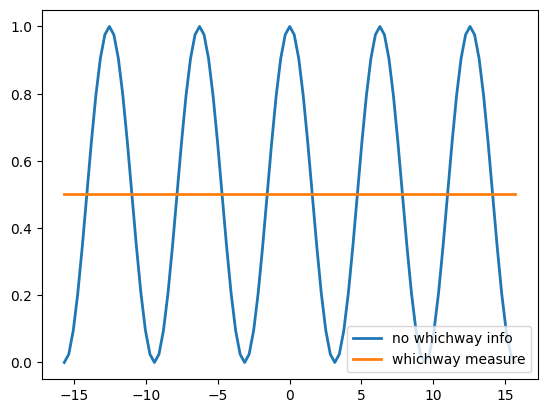

In [17]:
import matplotlib.pyplot as plt

from projectq import MainEngine
from projectq.backends import CircuitDrawer
from projectq.libs.hist import histogram
from projectq.setups.default import get_engine_list
from projectq.ops import CNOT, H, Measure, Rz, X, Z, Rx, Ry, R, CZ
from projectq.meta import Compute, Uncompute
from projectq.meta import Control, Dagger

from math import pi

def calc_circuit(eng, theta, whichway=False):
    b0 = eng.allocate_qubit()
    H | b0
    if whichway:
        Measure | b0
    R(theta) | b0
    H | b0
    eng.flush()
    prob = eng.backend.get_probability('0', b0)
    Measure | b0
    del b0
    return prob

# create a main compiler engine
drawing_engine = CircuitDrawer()
eng = MainEngine(engine_list=get_engine_list() + [drawing_engine])
N = 50
max_angle = 5*pi

x = []
y = []
for i in range(-N, N+1):
    theta = i*max_angle/N
    prob = calc_circuit(eng, theta)
    x.append(theta)
    y.append(prob)
    
x_which = []
y_which = []
for i in range(-N, N+1):
    theta = i*max_angle/N
    prob = calc_circuit(eng, theta, whichway=True)
    x_which.append(theta)
    y_which.append(prob)

# plot
#fig, ax = plt.subplots()

plt.plot(x, y, linewidth=2.0, label='no whichway info')
plt.plot(x_which, y_which, linewidth=2.0, label='whichway measure')
plt.legend(loc='lower right')
plt.show()


In [18]:
import matplotlib.pyplot as plt

from projectq import MainEngine
from projectq.backends import CircuitDrawer
from projectq.libs.hist import histogram
from projectq.setups.default import get_engine_list
from projectq.ops import CNOT, H, Measure, Rz, X, Z, Rx

# create a main compiler engine
drawing_engine = CircuitDrawer()
eng = MainEngine(engine_list=get_engine_list() + [drawing_engine])
b0 = eng.allocate_qubit()
H | b0
eng.flush()
print(eng.backend.get_amplitude('0', b0))
print(eng.backend.get_probability('0', b0))
Measure | b0
eng.flush()
a = eng.backend.get_amplitude('0', b0)
b = eng.backend.get_amplitude('1', b0)
print(eng.backend.get_probability('0', b0))
#print(a**2,b**2)
print(f"Measured {int(b0)}")  # output measurement result
#histogram(eng.backend, [b0])


(0.7071067811865475+0j)
0.4999999999999999
1.0
Measured 0


Alice entangled her qubit with her share of the Bell-pair.
Alice is sending the message [1, 0] to Bob.
Bob is trying to uncompute the state.
Bob successfully arrived at |0>


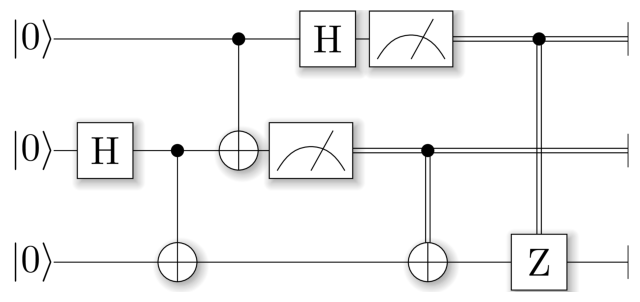

In [19]:
"""Example implementation of a quantum circuit generating a Bell pair state."""

import matplotlib.pyplot as plt
#from teleport import create_bell_pair

from projectq import MainEngine
from projectq.backends import CircuitDrawer
from projectq.libs.hist import histogram
from projectq.setups.default import get_engine_list
from projectq.meta import Compute, Uncompute
from projectq.meta import Control, Dagger

# we just want to draw the teleportation circuit
def state_creation_function(eng, qb):
    """Create a quantum state."""

verbose = True

# create a main compiler engine
drawing_engine = CircuitDrawer()
locations = {0: 1, 1: 2, 2: 0}

# drawing bug. right end not aligned.
#locations = {0: 0, 1: 1, 2: 2}
drawing_engine.set_qubit_locations(locations)

eng = MainEngine(engine_list=get_engine_list() + [drawing_engine])

def run(eng):
    qureg = eng.allocate_qureg(3)
    
    # create bell pair
    b1 = qureg[0]
    b2 = qureg[1]
    H | b1
    CNOT | (b1, b2)
    
    psi = qureg[2]
    
    # entangle it with Alice's b1
    CNOT | (psi, b1)
    if verbose:
        print("Alice entangled her qubit with her share of the Bell-pair.")
    
    # measure two values (once in Hadamard basis) and send the bits to Bob
    H | psi
    Measure | psi
    Measure | b1
    msg_to_bob = [int(psi), int(b1)]
    if verbose:
        print(f"Alice is sending the message {msg_to_bob} to Bob.")
    
    # Bob may have to apply up to two operation depending on the message sent
    # by Alice:
    with Control(eng, b1):
        X | b2
    with Control(eng, psi):
        Z | b2
    #CNOT | (psi, b2)
    
    # try to uncompute the psi state
    if verbose:
        print("Bob is trying to uncompute the state.")
    with Dagger(eng):
        state_creation_function(eng, b2)
    
    # check whether the uncompute was successful. The simulator only allows to
    # delete qubits which are in a computational basis state.
    del b2
    eng.flush()
    
    if verbose:
        print("Bob successfully arrived at |0>")

run(eng)
s = drawing_engine.get_latex()
s = s.replace(r'\end{tikzpicture}',
    r'\draw[operator,edgestyle,outer sep=0.5cm] ([yshift=0.25cm,xshift=-0.25cm]line2_gate3) rectangle ([yshift=-0.25cm,xshift=0.25cm]line2_gate3) node[pos=.5] {Z};'
    +'\n'
    +r'\end{tikzpicture}')
              
    
draw_tek(s, figsize=(8,8))

# Bell inequality

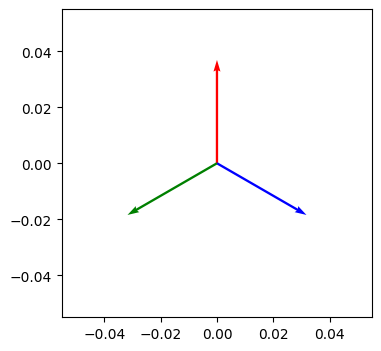

P12_same = 0.24999999999999994
P23_same = 0.25
P13_same = 0.24999999999999994
P12 + P23 + P13 = 0.7499999999999999  < 1
Bell's inequality violated.


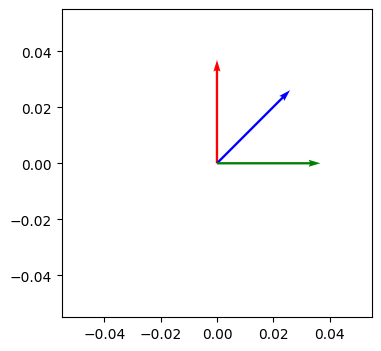

P12_same = 0.8535533905932735
P23_same = 0.8535533905932735
P13_same = 0.4999999999999999
P12 + P23 + P13 = 2.207106781186547  >= 1
Bell's inequality satisfied.


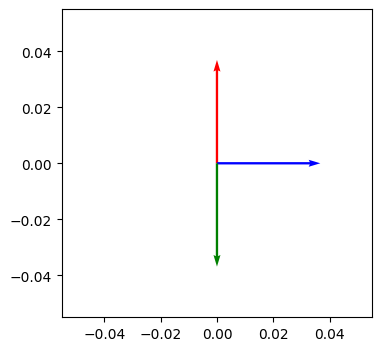

P12_same = 0.4999999999999999
P23_same = 0.4999999999999999
P13_same = 0.0
P12 + P23 + P13 = 0.9999999999999998  < 1
Bell's inequality violated.


In [20]:
"""Example implementation of a quantum circuit generating a Bell pair state."""

import matplotlib.pyplot as plt
#from teleport import create_bell_pair

from projectq import MainEngine
from projectq.backends import Simulator, CircuitDrawer
from projectq.libs.hist import histogram
from projectq.setups.default import get_engine_list
from projectq.meta import Compute, Uncompute
from projectq.meta import Control, Dagger
from projectq.ops import QubitOperator
#from projectq.ops import CNOT, H, Measure, Rz, X, Z, All
from projectq.ops import Measure, All, H, CNOT
import math

# create a main compiler engine
drawing_engine = CircuitDrawer()
#locations = {0: 1, 1: 2, 2: 0}

#drawing_engine.set_qubit_locations(locations)

#eng = MainEngine(engine_list=get_engine_list() + [drawing_engine])
sim = Simulator()
eng = MainEngine(engine_list=[sim, drawing_engine])

def create_bell_pair(eng):
    r"""
    Create a Bell pair state with two qubits.

    Returns a Bell-pair (two qubits in state :math:`|A\rangle \otimes |B \rangle = \frac 1{\sqrt 2} \left(
    |0\rangle\otimes|0\rangle + |1\rangle \otimes|1\rangle \right)`).

    Args:
        eng (MainEngine): MainEngine from which to allocate the qubits.

    Returns:
        bell_pair (tuple<Qubits>): The Bell-pair.
    """
    #b1 = eng.allocate_qureg(1)[0]
    #b2 = eng.allocate_qureg(1)[0]
    qureg = eng.allocate_qureg(2)
    b1 = qureg[0]
    b2 = qureg[1]

    H | b1
    CNOT | (b1, b2)

    return b1, b2, qureg

qb0, qb1, qureg = create_bell_pair(eng)

measure1 = [0,0,1]
measure2 = [math.sqrt(3)/2, 0, -1/2]
measure3 = [-math.sqrt(3)/2, 0, -1/2]
import numpy as np
import matplotlib.pyplot as plt

def draw_vector(v1, v2, v3):
    V = np.array([[v1[0],v1[2]],
                  [v2[0],v2[2]],
                  [v3[0],v3[2]]])
    origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

    plt.figure(figsize=(4,4))
    plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=3)
    plt.show()


def calc_measurements(a1, a2, a3):
    draw_vector(a1, a2, a3)
    sigma_b = [QubitOperator('X1'), QubitOperator('Y1'), QubitOperator('Z1')]
    #sigma = sigma*QubitOperator('Z0')

    def inner(n, sigma):
        return n[0]*sigma[0] + n[1]*sigma[1] + n[2]*sigma[2]
    
    HB1 = inner(a1, sigma_b)
    HB2 = inner(a2, sigma_b)
    HB3 = inner(a3, sigma_b)
    
    sigma_a = [QubitOperator('X0'), QubitOperator('Y0'), QubitOperator('Z0')]
    
    HA1 = inner(a1, sigma_a)
    HA2 = inner(a2, sigma_a)
    HA3 = inner(a3, sigma_a)
    
    I = QubitOperator('')
    
    #EA1u = 0.5*(I+HA1)
    #EA1d = 0.5*(I-HA1)
    #EA2u = 0.5*(I+HA2)
    #EA2d = 0.5*(I-HA2)
    #EA3u = 0.5*(I+HA3)
    #EA3d = 0.5*(I-HA3)
    
    #EB1u = 0.5*(I+HB1)
    #EB1d = 0.5*(I-HB1)
    #EB2u = 0.5*(I+HB2)
    #EB2d = 0.5*(I-HB2)
    #EB3u = 0.5*(I+HB3)
    #EB3d = 0.5*(I-HB3)
    
    #H11 = HA1*HB1
    #H12 = HA1*HB2
    #H13 = HA1*HB3
    #H21 = HA2*HB1
    #H22 = HA2*HB2
    #H23 = HA2*HB3
    #H31 = HA3*HB1
    #H32 = HA3*HB2
    #H33 = HA3*HB3
    
    #H11 = 0.5*H11+QubitOperator('X1')
    #H11.compress()
    eng.flush()
    #exp11 = eng.backend.get_expectation_value(H11, qureg)
    #exp12 = eng.backend.get_expectation_value(H12, qureg)
    #exp13 = eng.backend.get_expectation_value(H13, qureg)
    #exp21 = eng.backend.get_expectation_value(H21, qureg)
    #exp22 = eng.backend.get_expectation_value(H22, qureg)
    #exp23 = eng.backend.get_expectation_value(H23, qureg)
    #exp31 = eng.backend.get_expectation_value(H31, qureg)
    #exp32 = eng.backend.get_expectation_value(H32, qureg)
    #exp33 = eng.backend.get_expectation_value(H33, qureg)
    
    # cos theta verification
    #print('H11 =', exp11)
    #print('H12 =', exp12)
    #print('H13 =', exp13)
    #print('H21 =', exp21)
    #print('H22 =', exp22)
    #print('H23 =', exp23)
    #print('H31 =', exp31)
    #print('H32 =', exp32)
    #print('H33 =', exp33)
    
    def calc_probability(HA, HB):
        EAu = 0.5*(I+HA)
        EAd = 0.5*(I-HA)
        EBu = 0.5*(I+HB)
        EBd = 0.5*(I-HB)
        Puu = eng.backend.get_expectation_value(EAu*EBu, qureg)
        Pud = eng.backend.get_expectation_value(EAu*EBd, qureg)
        Pdu = eng.backend.get_expectation_value(EAd*EBu, qureg)
        Pdd = eng.backend.get_expectation_value(EAd*EBd, qureg)
        #print(Puu, Pud, Pdu, Pdd)
        return Puu+Pdd
    
    P12_same = calc_probability(HA1, HB2)
    P23_same = calc_probability(HA2, HB3)
    P13_same = calc_probability(HA1, HB3)
    print('P12_same =', P12_same)
    print('P23_same =', P23_same)
    print('P13_same =', P13_same)
    if P12_same + P23_same + P13_same < 1:
        print('P12 + P23 + P13 =', P12_same+P23_same+P13_same, ' < 1')
        print("Bell's inequality violated.")
    else:
        print('P12 + P23 + P13 =', P12_same+P23_same+P13_same, ' >= 1')
        print("Bell's inequality satisfied.")
        
calc_measurements(measure1, measure2, measure3)

measure1 = [0,0,1]
measure2 = [1/math.sqrt(2), 0, 1/math.sqrt(2)]
measure3 = [1,0,0]

calc_measurements(measure1, measure2, measure3)

measure1 = [0,0,1]
measure2 = [1,0,0]
measure3 = [0,0,-1]

calc_measurements(measure1, measure2, measure3)
    
All(Measure) | qureg

**소스 정리**

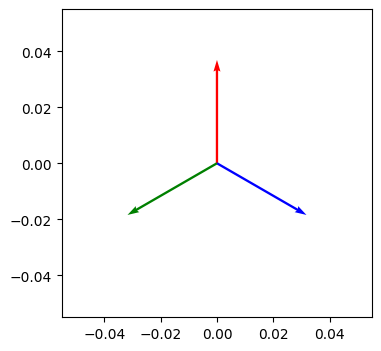

P12_same = 0.24999999999999994
P23_same = 0.25
P13_same = 0.24999999999999994
P12 + P23 + P13 = 0.7499999999999999  < 1
Bell's inequality violated.


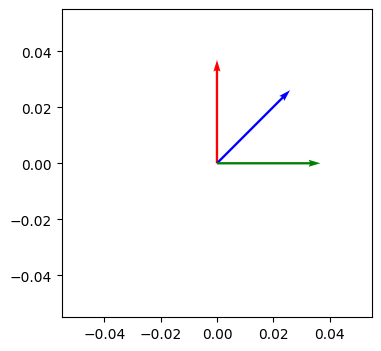

P12_same = 0.8535533905932735
P23_same = 0.8535533905932735
P13_same = 0.4999999999999999
P12 + P23 + P13 = 2.207106781186547  >= 1
Bell's inequality satisfied.


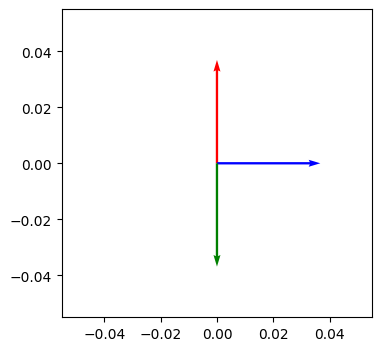

P12_same = 0.4999999999999999
P23_same = 0.4999999999999999
P13_same = 0.0
P12 + P23 + P13 = 0.9999999999999998  < 1
Bell's inequality violated.


In [21]:
"""Example implementation of a quantum circuit generating a Bell pair state."""

import matplotlib.pyplot as plt
#from teleport import create_bell_pair

from projectq import MainEngine
from projectq.backends import Simulator, CircuitDrawer
from projectq.libs.hist import histogram
from projectq.setups.default import get_engine_list
from projectq.meta import Compute, Uncompute
from projectq.meta import Control, Dagger
from projectq.ops import QubitOperator
#from projectq.ops import CNOT, H, Measure, Rz, X, Z, All
from projectq.ops import Measure, All, H, CNOT
import math

# create a main compiler engine
drawing_engine = CircuitDrawer()
#locations = {0: 1, 1: 2, 2: 0}

#drawing_engine.set_qubit_locations(locations)

#eng = MainEngine(engine_list=get_engine_list() + [drawing_engine])
sim = Simulator()
eng = MainEngine(engine_list=[sim, drawing_engine])

def create_bell_pair(eng):
    r"""
    Create a Bell pair state with two qubits.

    Returns a Bell-pair (two qubits in state :math:`|A\rangle \otimes |B \rangle = \frac 1{\sqrt 2} \left(
    |0\rangle\otimes|0\rangle + |1\rangle \otimes|1\rangle \right)`).

    Args:
        eng (MainEngine): MainEngine from which to allocate the qubits.

    Returns:
        bell_pair (tuple<Qubits>): The Bell-pair.
    """
    #b1 = eng.allocate_qureg(1)[0]
    #b2 = eng.allocate_qureg(1)[0]
    qureg = eng.allocate_qureg(2)
    b1 = qureg[0]
    b2 = qureg[1]

    H | b1
    CNOT | (b1, b2)

    return b1, b2, qureg

qb0, qb1, qureg = create_bell_pair(eng)

measure1 = [0,0,1]
measure2 = [math.sqrt(3)/2, 0, -1/2]
measure3 = [-math.sqrt(3)/2, 0, -1/2]
import numpy as np
import matplotlib.pyplot as plt

def draw_vector(v1, v2, v3):
    V = np.array([[v1[0],v1[2]],
                  [v2[0],v2[2]],
                  [v3[0],v3[2]]])
    origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

    plt.figure(figsize=(4,4))
    plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=3)
    plt.show()


def calc_measurements(a1, a2, a3):
    draw_vector(a1, a2, a3)
    sigma_b = [QubitOperator('X1'), QubitOperator('Y1'), QubitOperator('Z1')]
    #sigma = sigma*QubitOperator('Z0')

    def inner(n, sigma):
        return n[0]*sigma[0] + n[1]*sigma[1] + n[2]*sigma[2]
    
    HB1 = inner(a1, sigma_b)
    HB2 = inner(a2, sigma_b)
    HB3 = inner(a3, sigma_b)
    
    sigma_a = [QubitOperator('X0'), QubitOperator('Y0'), QubitOperator('Z0')]
    
    HA1 = inner(a1, sigma_a)
    HA2 = inner(a2, sigma_a)
    HA3 = inner(a3, sigma_a)
    
    I = QubitOperator('')
    
    def calc_probability(HA, HB):
        EAu = 0.5*(I+HA)
        EAd = 0.5*(I-HA)
        EBu = 0.5*(I+HB)
        EBd = 0.5*(I-HB)
        Puu = eng.backend.get_expectation_value(EAu*EBu, qureg)
        Pud = eng.backend.get_expectation_value(EAu*EBd, qureg)
        Pdu = eng.backend.get_expectation_value(EAd*EBu, qureg)
        Pdd = eng.backend.get_expectation_value(EAd*EBd, qureg)
        return Puu+Pdd
    
    P12_same = calc_probability(HA1, HB2)
    P23_same = calc_probability(HA2, HB3)
    P13_same = calc_probability(HA1, HB3)
    print('P12_same =', P12_same)
    print('P23_same =', P23_same)
    print('P13_same =', P13_same)
    if P12_same + P23_same + P13_same < 1:
        print('P12 + P23 + P13 =', P12_same+P23_same+P13_same, ' < 1')
        print("Bell's inequality violated.")
    else:
        print('P12 + P23 + P13 =', P12_same+P23_same+P13_same, ' >= 1')
        print("Bell's inequality satisfied.")
        
calc_measurements(measure1, measure2, measure3)

measure1 = [0,0,1]
measure2 = [1/math.sqrt(2), 0, 1/math.sqrt(2)]
measure3 = [1,0,0]

calc_measurements(measure1, measure2, measure3)

measure1 = [0,0,1]
measure2 = [1,0,0]
measure3 = [0,0,-1]

calc_measurements(measure1, measure2, measure3)
    
All(Measure) | qureg

In [22]:
# Quantum Eraser

**[Chiou2022] Quantum Eraser에 대한 quantum circuit**

[Complementarity relations of a delayed-choice quantum eraser in a...](https://arxiv.org/abs/2207.03946)

In [111]:
import matplotlib.pyplot as plt

from projectq import MainEngine
from projectq.backends import CircuitDrawer
from projectq.libs.hist import histogram
from projectq.setups.default import get_engine_list
from projectq.ops import CNOT, H, Measure, Rz, X, Z, Rx, Ry, R, CZ
from projectq.meta import Compute, Uncompute
from projectq.meta import Control, Dagger

from math import pi

def create_bell_pair(eng):
    r"""
    Create a Bell pair state with two qubits.

    Returns a Bell-pair (two qubits in state :math:`|A\rangle \otimes |B \rangle = \frac 1{\sqrt 2} \left(
    |0\rangle\otimes|0\rangle + |1\rangle \otimes|1\rangle \right)`).

    Args:
        eng (MainEngine): MainEngine from which to allocate the qubits.

    Returns:
        bell_pair (tuple<Qubits>): The Bell-pair.
    """
    b1 = eng.allocate_qureg(1)[0]
    b2 = eng.allocate_qureg(1)[0]

    # slightly modified. is it same???
    H | b2
    CNOT | (b2, b1)

    return b1, b2
    
def calc_circuit(eng, theta, erase=False):
    b1, b2 = create_bell_pair(eng)
    
    H | b1
    R(theta) | b1
    H | b1
    Measure | b1
    D_i = int(b1)
    
    if erase:
        phi = math.pi/2
    else:
        phi = 0

    Rz(phi) | b2
    Measure | b2
    D_d = int(b2)

    eng.flush()
    del b1, b2

    return D_i, D_d

# create a main compiler engine
drawing_engine = CircuitDrawer()
eng = MainEngine(engine_list=get_engine_list() + [drawing_engine])

val1, val2 = calc_circuit(eng, 0)
print(val1, val2)

0 0


**[Tian2022]**

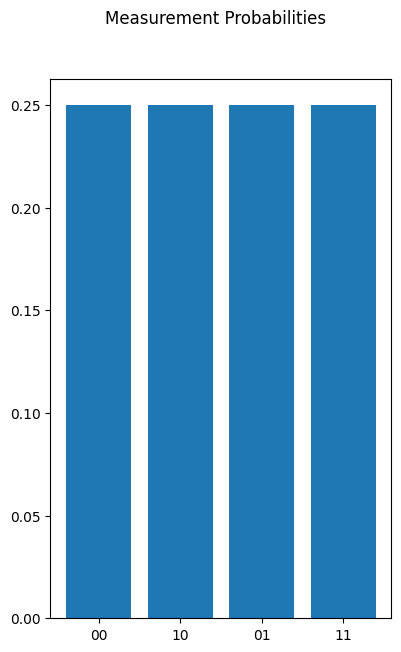

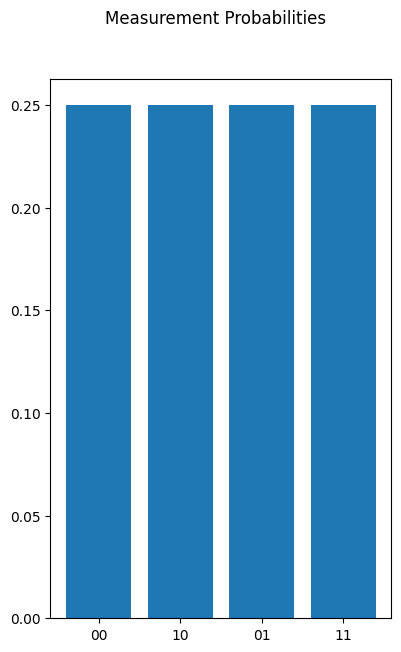

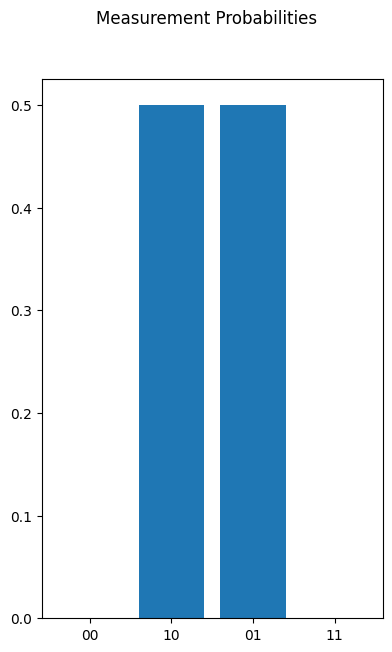

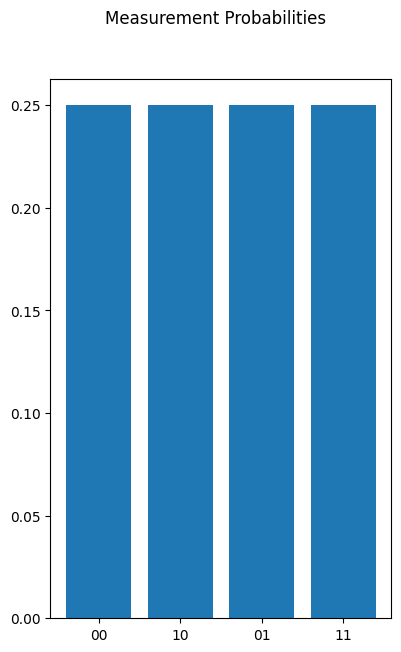

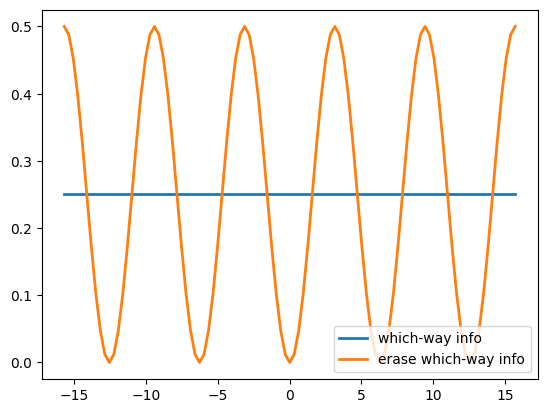

In [142]:
import matplotlib.pyplot as plt

from projectq import MainEngine
from projectq.backends import CircuitDrawer
from projectq.libs.hist import histogram
from projectq.setups.default import get_engine_list
from projectq.ops import CNOT, H, Measure, Rz, X, Z, Rx, Ry, R, CZ
from projectq.meta import Compute, Uncompute
from projectq.meta import Control, Dagger

from math import pi

def calc_circuit(eng, theta, erase=False, simulator=True, plot_histogram=False):
    
    # create bell pair
    b1 = eng.allocate_qureg(1)[0]
    b2 = eng.allocate_qureg(1)[0]
    H | b1
    CNOT | (b1, b2)

    # interference path delay: theta
    R(theta) | b1
    H | b1
    #Measure | b1
    #D_i = int(b1)
    
    if erase:
        phi = math.pi/2
    else:
        phi = 0

    #Rz(phi) | b2
    #Measure | b2
    #D_d = int(b2)
    Ry(phi) | b2

    eng.flush()
    if plot_histogram:
        histogram(eng.backend, [b1, b2])
        plt.show()
    if simulator:
        p_00 = eng.backend.get_probability('00', [b1, b2])
        p_01 = eng.backend.get_probability('01', [b1, b2])
        p_10 = eng.backend.get_probability('10', [b1, b2])
        p_11 = eng.backend.get_probability('11', [b1, b2])
        #print('00, 10, 01, 11 =', p_00, p_10, p_01, p_11)

    Measure | b1
    Measure | b2
    del b1, b2
    
    if simulator:
        return p_00

    D_i = 0
    D_d = 0
    return D_i

# create a main compiler engine
drawing_engine = CircuitDrawer()
eng = MainEngine(engine_list=get_engine_list() + [drawing_engine])

calc_circuit(eng, 0, plot_histogram=True)
calc_circuit(eng, pi/2, plot_histogram=True)
calc_circuit(eng, 0, erase=True, plot_histogram=True)
calc_circuit(eng, pi/2, erase=True, plot_histogram=True)

N = 50
max_angle = 5*pi

x = []
y = []
for i in range(-N, N+1):
    theta = i*max_angle/N
    prob = calc_circuit(eng, theta, erase=False)
    x.append(theta)
    y.append(prob)
    
x_erase = []
y_erase = []
for i in range(-N, N+1):
    theta = i*max_angle/N
    prob = calc_circuit(eng, theta, erase=True)
    x_erase.append(theta)
    y_erase.append(prob)

plt.plot(x, y, linewidth=2.0, label='which-way info')
plt.plot(x_erase, y_erase, linewidth=2.0, label='erase which-way info')
plt.legend(loc='lower right')
plt.show()


In [5]:
# pylint: skip-file

"""Example of running a quantum circuit using the IBM QE APIs."""

import getpass

import matplotlib.pyplot as plt

import projectq.setups.ibm
from projectq import MainEngine
from projectq.backends import IBMBackend
from projectq.libs.hist import histogram
from projectq.ops import All, Entangle, Measure


def run_entangle(eng, num_qubits=3):
    """
    Run an entangling operation on the provided compiler engine.

    Args:
        eng (MainEngine): Main compiler engine to use.
        num_qubits (int): Number of qubits to entangle.

    Returns:
        measurement (list<int>): List of measurement outcomes.
    """
    # allocate the quantum register to entangle
    qureg = eng.allocate_qureg(num_qubits)

    # entangle the qureg
    Entangle | qureg

    # measure; should be all-0 or all-1
    All(Measure) | qureg

    # run the circuit
    eng.flush()

    # access the probabilities via the back-end:
    # results = eng.backend.get_probabilities(qureg)
    # for state in results:
    #     print(f"Measured {state} with p = {results[state]}.")
    # or plot them directly:
    histogram(eng.backend, qureg)
    plt.show()

    # return one (random) measurement outcome.
    return [int(q) for q in qureg]


if __name__ == "__main__":
    # devices commonly available :
    # ibmq_16_melbourne (15 qubit)
    # ibmq_essex (5 qubit)
    # ibmq_qasm_simulator (32 qubits)
    # and plenty of other 5 qubits devices!
    #
    # To get a token, create a profile at:
    # https://quantum-computing.ibm.com/
    #
    device = None  # replace by the IBM device name you want to use
    token = None  # replace by the token given by IBMQ

    #device = 'ibmq_qasm_simulator'
    device = 'ibm_nairobi'
    token = '8916d1d8c9e6e373407ca4fe61010619f18832bfb2244920b679a8fadeac834cb127fb7b7a0c24c2b4b96b63f6b3a922fe0cfe56337a3cd2f470c2ae08e2554d'
    if token is None:
        token = getpass.getpass(prompt='IBM Q token > ')
    if device is None:
        device = getpass.getpass(prompt='IBM device > ')
    # create main compiler engine for the IBM back-end
    #engine_list=projectq.setups.ibm.get_engine_list(token=token, device=device),
    eng = MainEngine(
        IBMBackend(use_hardware=True, token=token, num_runs=1024, verbose=False, device=device),
        engine_list=projectq.setups.ibm.get_engine_list(token=token, device=device),
    )
    # run the circuit and print the result
    print(run_entangle(eng))

DeviceNotHandledError: Device not yet fully handled by ProjectQ

In [150]:
!pip install projectq==sdf

ERROR: Ignored the following yanked versions: 0.6.1
ERROR: Could not find a version that satisfies the requirement projectq==sdf (from versions: 0.1.0, 0.1.1, 0.1.2, 0.1.3, 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 0.3.4, 0.3.5, 0.3.6, 0.4, 0.4.1, 0.4.2, 0.5.0.dev0, 0.5.0.dev1, 0.5.0, 0.5.1, 0.6.1.post0, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.0)
ERROR: No matching distribution found for projectq==sdf


In [151]:
!pip install projectq==0.8.0

  Using cached projectq-0.8.0-cp38-cp38-linux_x86_64.whl
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: projectq
    Found existing installation: projectq 0.7.3
    Uninstalling projectq-0.7.3:
      Successfully uninstalled projectq-0.7.3
